# Prueba ténica Newtral

---


Borja Lozano Álvarez

lozanoalvarez.b@gmail.com

--- 
Finetune de Transformers para la clasificación de frases verificables. El modelo con el mejor rendimiento se puede probar en la seccion *Anexo: Prueba el modelo!*

## Objetivos

* Descarga el dataset en formato CSV del siguiente enlace https://ml-coding-test.s3.eu-west-1.amazonaws.com/ml_test_data.csv . Cada fila es una frase y su etiqueta indicando si es verificable (1) o no (0).

* Crea un notebook con la solución a las tareas indicadas debajo. Te recomendamos utilizar Google Colab para disponer de recursos de cómputo gratuitos.

* Incluye un análisis descriptivo de los datos. No es necesario que sea muy exhaustivo, céntrate en los aspectos más importantes para el funcionamiento del modelo.

* Crea un modelo de detección de frases verificables utilizando la técnica de fine-tuning de un modelo pre-entrenado de tipo BERT (es decir, son válidos cualquier checkpoint de BERT o modificaciones como RoBERTa, XLM, etc). Puedes utilizar librerías y checkpoints como Huggingface Transformers, o cualquier otro a tu elección.

* Evalúa tu solución a través de un conjunto de test. Elige las métricas que consideres más adecuadas para el problema y añade un párrafo interpretando tus resultados.

* Incluye un pequeño análisis de errores sobre el conjunto de test, que explique en qué tipo de situaciones tu modelo falla.

* Utiliza Python>=3.6 y las librerías que desees de computación científica y machine learning del ecosistema Python.

* Comparte tu notebook a través de un repositorio de GitHub público y envíanos el enlace.



# Setup

In [2]:
#@markdown Instalar librerias
%%capture
# Descomentar para usar Weights and Biases
!pip install transformers datasets wandb sentencepiece gradio gdown torch

In [3]:
#@markdown Importar librerias
import datasets
import wandb
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import torch

In [ ]:
#@markdown Principales parametros
dataset_url = 'https://ml-coding-test.s3.eu-west-1.amazonaws.com/ml_test_data.csv'
#@markdown Modelo RoBERTa de [Gutiérrez-Fandiño, Asier, et al. "Spanish language models." (2021)](https://arxiv.org/pdf/2107.07253.pdf). De todos los modelos de lenguage pre-entrenados en español es con diferencia el que mejor puntuación obtiene
model_checkpoint="BSC-TeMU/roberta-base-bne" #@param ['BSC-TeMU/roberta-base-bne','dccuchile/bert-base-spanish-wwm-uncased','bertin-project/bertin-roberta-base-spanish']

metric_names = ['precision','recall','accuracy','f1']
metric_for_best_model = "f1" #@param ['precision','recall','accuracy','f1']

batch_size = 32  #@param [8,16,32]
lr = 2e-5  #@param {type:"number"}

# Make plots bigger
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 #@param{type:"slider", min:50, max:110, step:10}

device = 0 if torch.cuda.is_available() else -1

#@markdown Si tienes cuenta en wandb puedes usarla para registrar las estadísticas y guardar los modelos
use_wandb = False #@param {type:"boolean"}
%env WANDB_PROJECT=newtral_prueba #@param 
%env WANDB_LOG_MODEL=True #@param {type:"boolean"}
if use_wandb:
  %env WANDB_DISABLED=False
else:
  %env WANDB_DISABLED=True

In [ ]:
#@markdown Descargar datos y modelos
%%capture
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model_pretrained = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

!mkdir best_model
%cd best_model
!gdown "https://drive.google.com/uc?export=download&id=1at6y1sr5ZxcATZXD5Jz1JYCaq9mTINtH" 
!gdown "https://drive.google.com/uc?export=download&id=1Mtju2rT6RtiJwSpQvuc2TON7WOE5Rwf3"
%cd ..

data = pd.read_csv(dataset_url)

# Análisis del dataset

In [6]:
#@markdown El dataset se compone de 15000 frases las cuales pueden ser verificables o no. Abajo se muestran varios ejemplos
from collections import defaultdict
from statistics import mean,median
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    if isinstance(dataset,pd.core.frame.DataFrame):
      df = dataset.iloc[picks]
    else:
      df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(data)

,text,claim
12416,"Bueno yo me quedo con lo que importa también, que es la imagen de la visión y la visibilización de nuestro país en todas sus dimensiones, en todas sus comunidades autónomas.",0
4591,Es la mudanza que tiene que hacer España y hasta la Moncloa.,0
10203,Antes Mònica le preguntaba que lo baje.,0
883,Lo que nos encontramos son una una una posibilidad de indultos por parte del Gobierno de España en contra de los informes del Tribunal Supremo y de la Fiscalía General del Estado y además contrarios al sentirles general de la inmensa mayoría de los españoles.,0
695,"Muchas gracias, Andrea.",0
14216,"O sea, si no se puede dialogar yo creo con una fuerza política que tiene a sus principales líderes en prisión.",0
4344,"Nos conocemos algo, eh?",0
13327,"La Unión Europea surge contra el nacionalismo y surge contra el populismo, que son precisamente los fantasmas que otra vez amenazan nuestra prosperidad y nuestra libertad.",0
9897,Dónde está ese medio millón de hogares que estaban en una simulación?,0
13200,Ya alguna de esas prestaciones las vamos a incorporar de facto ya en seguida.,0



Vamos a investigar tres variables de interés:
* **Número de ejemplos y balance entre clases**. Si el dataset no esta balanceado es posible que el modelo aprenda incorrectamente a clasificar todos los ejemplos de una clase o no reciba señal suficiente de la clase minoritaria, impidiendo asi que aprenda las características que le permitiran distinguirlo.
* **Tamaño del vocabulario**. En sistemas PLN clasicos el vocabulario y la distribución de este podrian ser usados como parte de las *features* con las que el modelo aprendería a clasificar. Una de las ventajas de las arquitecturas basadas en *Deep Learning* aprenden que características de manera automática. Aun así, comprobar la distribución del vocabulario entre las clases nos puede guiar al predecir el comportamiento de estos sistemas o ayudar a  *debugear* el entrenamiento.
* **Tamaño medio de las frases**. La mayoría de las arquitecturas *Transformer* tienen como limitación un tamaño máximo. Existen varias opciones para los ejemplos que sobrepasan este limite. El más simple es truncar dicho ejemplo a un tamaño máximo, pero es posible que perdamos información. En caso de darse este problema en varios ejemplos podríamos utilizar metodos como las ventanas deslizantes y el *pooling*.  

In [7]:
#@markdown Variables de interes
positive_indices = [i for i, label in enumerate(data['claim']) if label]
n_positives = [len(positive_indices)]
n_negatives = [len(data)-len(positive_indices)]
pcts = [len(positive_indices)/len(data)]

vocab = defaultdict(set)
lengths = defaultdict(list)
for index, row in data.iterrows():
  vocab[row['claim']].update(row['text'].split())
  lengths[row['claim']].append(len(row['text'].split()))


print(
f"""
Tamaño del dataset: {len(data)}
Numero de ejemplos verificables: {len(positive_indices)}

Tamaño del vocabulario: {len(vocab[0].union(vocab[1]))}
Tamaño del vocabulario verificable: {len(vocab[1])}
Numero de palabras compartidas entre 
las frases verificables y no verificables:  {len(vocab[0].intersection(vocab[1]))}

Tamaño medio del texto: {mean([*lengths[0],*lengths[1]]):.1f}
Tamaño medio del texto no verificable: {mean(lengths[0]):.1f}
Tamaño medio del texto verificable: {mean(lengths[1]):.1f}

Tamaño mediano del texto: {median([*lengths[0],*lengths[1]])}
Tamaño mediano del texto no verificable: {median(lengths[0])}
Tamaño mediano del texto verificable: {median(lengths[1])}
"""
)


Tamaño del dataset: 15000
Numero de ejemplos verificables: 1081

Tamaño del vocabulario: 26789
Tamaño del vocabulario verificable: 6479
Numero de palabras compartidas entre 
las frases verificables y no verificables:  4659

Tamaño medio del texto: 19.0
Tamaño medio del texto no verificable: 18.2
Tamaño medio del texto verificable: 30.0

Tamaño mediano del texto: 15.0
Tamaño mediano del texto no verificable: 14
Tamaño mediano del texto verificable: 27



El dataset esta claramente desbalanceado, con un solo un ~7% de frases verificables. Como se ha comentado anteriormente el problema del desbalance de clases puede resultar en clasificadores que aprenden incorrectamente a clasificar en la clase mayoritaria a todos los ejemplos [[H. He and E. A. Garcia 2009](https://ieeexplore.ieee.org/abstract/document/5128907)].
En terminos generales, si el desbalance es *intrínseco* (los datos han sido recogidos correctamente y la clase minoritaria se percive con menor frecuencia) es vital escoger métricas que nos permitan destacar la clase minoritaria en nuestro clasificador. El dataset que nos concierne tiene un claro caso de uso como filtro de frases no verificables por lo que el coste de un falso positivo frente a un falso negativo no es el mismo. Idealmente el modelo debería ser capaz de identificar todas las frases verificables aunque en clasifique incorrectamente una pequeña porción de frases no verificables (falsos positivos).

Sorpendentemente las frases verificables comparten poco vocabulario con el resto, señal que debería ser util al durante el *finetuning*. Esta discordancia puede deberse también al desbalanceo de clases. Otra hipótesis basada en [Horne et.al. 2017](https://arxiv.org/pdf/1703.09398.pdf) sugeriría que una gran parte de las frases verificables podrían propagar desinformación debido a la naturaleza repetitiva y simplista de esta.

Por último el tamaño de las frases vuelve a significar la diferencia entre ambas clases. La media y mediana indican que ambas distribuciones son asimetricas, pero  las frases **no** verificables tienen a ser mucho más cortas.  


# Finetune


## Dev y Test Sets


Para evaluar los modelos usamos un metodo *hold-out* dividiendo el dataset en tres splits (los porcentajes para cada split se han establecido siguiendo las indicaciones de [Williams, Evan, et.al. 2021](https://arxiv.org/abs/2107.05684)):
*   80% para el conjunto de entrenamiento con el que haremos el finetune. 
*   4% para el conjunto de validación/desarollo. Para poder escoger el mejor checkpoint durante el entrenamiento.
*   16% para el conjunto de test. Será el dataset con el que evaluaremos los modelos y sobre el que se analizaran los errores.

Es importante que al dividir los conjuntos la distribución de cada uno siga siendo similar a la del dataset original. Para ello dividimos de forma estratificada basandos en el número de ejempos de cada clase.

In [ ]:
from sklearn.model_selection import train_test_split
text_train, text_dev_test, claim_train, claim_dev_test = train_test_split(data['text'], data['claim'], test_size=0.2, random_state=0)
text_test, text_dev, claim_test, claim_dev = train_test_split(text_dev_test, claim_dev_test, test_size=0.2, random_state=0)

train = datasets.Dataset.from_dict({
    'text':text_train,
    'labels':claim_train
})

dev = datasets.Dataset.from_dict({
    'text':text_dev,
    'labels':claim_dev
})

test = datasets.Dataset.from_dict({
    'text':text_test,
    'labels':claim_test
})

splits = datasets.DatasetDict({
    'train':train,
    'dev':dev,
    'test':test
})


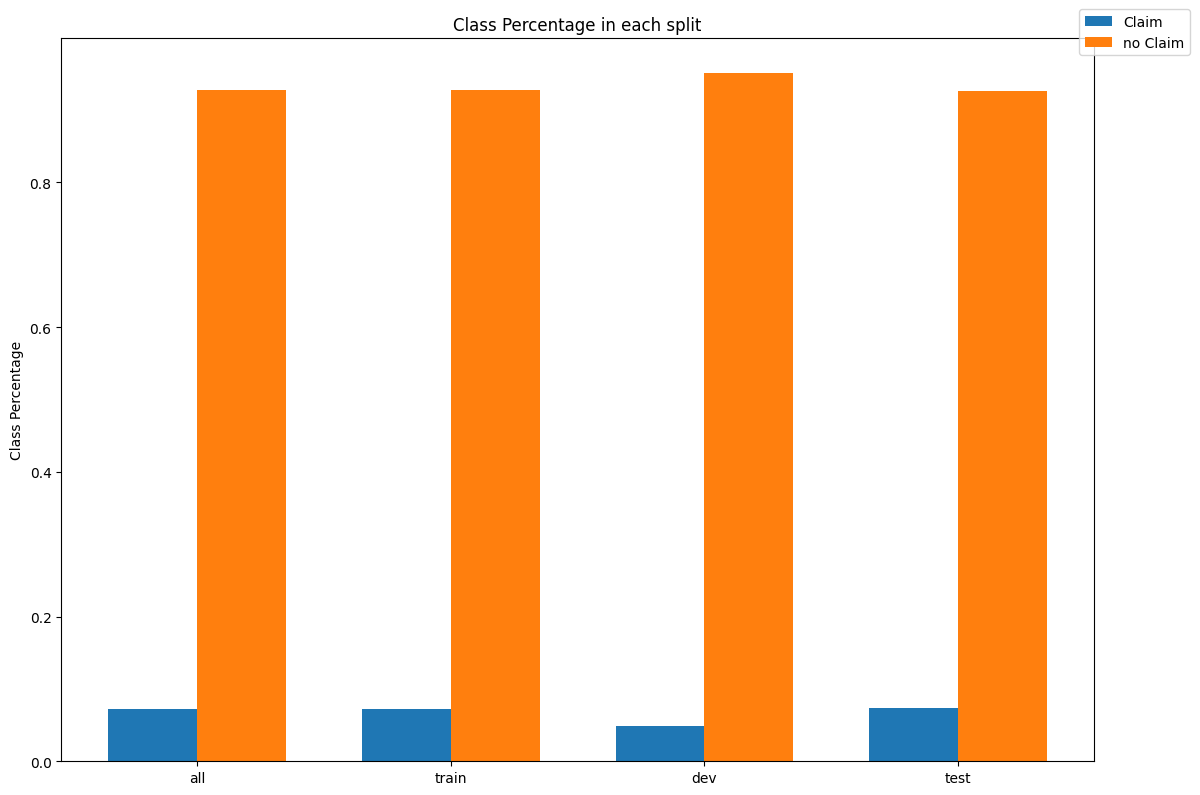

In [ ]:
#@markdown  Como se puede observar en el plot inferior la distribución de ejemplos en los distintos splits se mantiene

n_positives = [len(positive_indices)]
n_negatives = [len(data)-len(positive_indices)]
pcts = [len(positive_indices)/len(data)]
for split in splits:
  positive_indices = [i for i, label in enumerate(splits[split]['labels']) if label]
  pcts.append(len(positive_indices)/len(splits[split]))
  n_positives.append(len(positive_indices))
  n_negatives.append(len(splits[split])-len(positive_indices))


pcts_claim = np.array(pcts)
pcts_noclaim = np.ones(4) - pcts

x = np.arange(4)
width = 0.35  

fig, ax = plt.subplots()
positive_bar = ax.bar(x - width/2, pcts_claim, width, label='Claim')
negative_bar = ax.bar(x + width/2, pcts_noclaim, width, label='no Claim')


ax.set_ylabel('Class Percentage')
ax.set_title('Class Percentage in each split')
ax.set_xticks(x)
ax.set_xticklabels(['all','train', 'dev', 'test'])
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig.tight_layout()

Para poder evaluar correctamente usando el conjunto *dev* y *test* necesitamos métricas que favorezcan la clasificación de frases verificables. Para ello usaremos tres métricas

*   **Precision**. Proporción entre las frases clasificadas como verificables que realmente lo son.
*   **Recall**. Propoción de frases anotadas como verificables que han sido correctamente clasificadas.
*   **F1**. Media harmónica de las metricas *precision* y *recall*. Nos permite obtener un valor numérico con el que comparar modelos cuando queremos maximizar ambas metricas de forma concurrente. Esta será la métrica que usemos para escoger entre los modelos.

En la sección Finetune usaremos técnicas enfocadas a mejorar el rendimiento para datasets balanceados. **Es importante remarcar que para evaluar el modelo correctamente estas tecnicas unicamente  han de cambiar el conjunto de entrenamiento**, los datos de evaluación y test han de mantener siempre la distribución original.


In [ ]:
from transformers import EvalPrediction
from sklearn.metrics import confusion_matrix
metrics = [datasets.load_metric(metric) for metric in metric_names]

def compute_metrics(p: EvalPrediction):
  """
  Calcula las metricas de la lista metrics.
  Cada predicción de los modelos [MODEL_NAME]ForSequenceClassification es un 
  array de dimensiones == n_labels. Para compararlo con los labels se clasifica
  cada ejemplo en base a la clase mas probable 
  """
  preds = np.argmax(p.predictions, axis=1)
  
  tn, fp, fn, tp = confusion_matrix(y_true=p.label_ids,
                                    y_pred=preds).ravel()
  scores = {
      "TP":tp,
      "FP":fp,
      "TN":tn,
      "FN":fn
  }
  for metric in metrics:
    if metric.name == 'f1':
      positive_index = [i for i,label in enumerate(p.label_ids) if label == 1]
      f1_positives = metric.compute(predictions=preds[positive_index],
                                    references=p.label_ids[positive_index])
      scores.update({'f1_positive':f1_positives['f1']})
    scores.update(metric.compute(predictions=preds, references=p.label_ids))
  return scores


show_metric_example = False #@param {type:"boolean"}
if show_metric_example:
  fake_preds = np.random.random((64,2))
  fake_labels = np.random.choice([0,1],p=[0.93,0.07], size=(64,))
  preds = np.argmax(fake_preds, axis=1)
  print(f"Fake Labels\n{fake_labels}")
  print(f"Fake Predictions\n{preds}")
  print(compute_metrics(EvalPrediction(fake_preds, fake_labels)))

## Unbalanced dataset

El primer finetune lo realizaremos con el split de entrenamiento sin modificar. Esto nos permitirá establecer un *baseline* con el que comparar posibles mejoras.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
# Tokenizamos el dataset
encoded_dataset = splits.map(lambda example: tokenizer(example['text'],truncation=True), batched=True)

def train_and_predict(trainer):
  trainer.train()
  predictions = trainer.predict(encoded_dataset['test'])
  cm = np.array([[predictions.metrics['test_TP'],predictions.metrics['test_FN']],
               [predictions.metrics['test_FP'],predictions.metrics['test_TN']]])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['verificable','no verificable'])

  disp.plot() 
  disp.ax_.set_title(f"Test on {trainer.args.run_name} model")
  wandb.log({metric.replace('_','/',1):predictions.metrics[metric] for metric in predictions.metrics})
  wandb.finish()

###Train unbalanced

In [ ]:
args = TrainingArguments(
    "test-newtral",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    save_total_limit=1,
    report_to="wandb",
    logging_strategy="steps",
    logging_steps=10,
    run_name="unbalanced"
)

trainer = Trainer(
    model_pretrained,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
train_and_predict(trainer)

## Oversampling

El *Oversampling* consiste en añadir al *dataset* ejemplos repetidos de la clase minoritaria, balanceado así el dataset.

In [ ]:
def split_binary_dataset(dataset):
  indices_positive, indices_negative = [],[]
  for i,claim in enumerate(dataset['labels']):
    if claim:
      indices_positive.append(i)
    else:
      indices_negative.append(i)

  dataset_positive = datasets.Dataset.from_dict(dataset[indices_positive])
  dataset_negative = datasets.Dataset.from_dict(dataset[indices_negative])

  assert len(dataset_positive)+len(dataset_negative) == len(dataset)
  return dataset_positive,dataset_negative

dataset_claim,dataset_noClaim = split_binary_dataset(splits['train'])

In [ ]:
oversample_indices_positive = []
for _ in range(len(dataset_noClaim)-len(dataset_claim)):
    pick = random.randint(0, len(dataset_claim)-1)
    oversample_indices_positive.append(pick)
oversampled_positives = datasets.Dataset.from_dict(dataset_claim[oversample_indices_positive])

dataset_oversampled = datasets.concatenate_datasets([splits['train'],oversampled_positives])

###Train oversampled

Actualizamos los argumentos y volvemos a entrenar.

In [ ]:
encoded_dataset_oversampled = dataset_oversampled.map(lambda example: tokenizer(example['text'],truncation=True), batched=True)

args = TrainingArguments(
    "test-newtral",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    save_total_limit=1,
    report_to="wandb",
    logging_strategy="steps",
    logging_steps=10,
    run_name="oversample"
)

trainer = Trainer(
    model_pretrained,
    args,
    train_dataset= encoded_dataset_oversampled,
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
train_and_predict(trainer)

## MT Data Augmentation
Los ganadores de la tarea de clasificación de *claims* durante competición *CheckThat!* 2020 [[Williams, E., et. al. 2020](https://arxiv.org/abs/2009.02431)] utilizaron modelos de traducción automatica para conseguir nuevos datos de entrenamiento. Su técnica se basa en traducir las frases verificables para despues volverlas a traducir al idioma original, consiguiendo ejemplos alternativos que expresen conceptos similares.

Para replicar su método usaremos dos traductores de español-ingles y de ingles-español para duplicar el número de ejemplos verificables en nuestro dataset de entrenamiento.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TranslationPipeline
  
es_en_mt_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-es-en")
es_en_mt_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-es-en")
es_en_pipeline = TranslationPipeline(es_en_mt_model,es_en_mt_tokenizer,device=device)

en_es_mt_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
en_es_mt_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es")
en_es_pipeline = TranslationPipeline(en_es_mt_model,en_es_mt_tokenizer,device=device)

In [ ]:
dataset_claim,dataset_noClaim = split_binary_dataset(splits['train'])

def prepare_mt_oversamples(examples):
  translate = [translation['translation_text'] for translation in es_en_pipeline(examples['text'])]
  examples['text'] = [translation['translation_text'] for translation in en_es_pipeline(translate)]
  return examples

dataset_claim_mt = dataset_claim.map(prepare_mt_oversamples,batched=True,batch_size=32)

In [ ]:
dataset_mt = datasets.concatenate_datasets([splits['train'],
                                            datasets.Dataset.from_dict({'text':dataset_claim_mt['text'],'labels':dataset_claim_mt['labels']})])
dataset_mt_oversampled = datasets.concatenate_datasets([splits['train'],
                                            datasets.Dataset.from_dict({'text':oversampled_positives['text'],'labels':oversampled_positives['labels']})])
oversample_indices_positive = []
for _ in range(len(dataset_noClaim)-len(dataset_claim)):
    pick = random.randint(0, len(dataset_claim)-1)
    oversample_indices_positive.append(pick)
oversampled_positives = datasets.Dataset.from_dict(dataset_claim_mt[oversample_indices_positive])




###Train mt

In [ ]:
encoded_mt = dataset_mt.map(lambda example: tokenizer(example['text'],truncation=True), batched=True)
args = TrainingArguments(
    "test-newtral",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    save_total_limit=1,
    report_to="wandb",
    logging_strategy="steps",
    logging_steps=10,
    run_name="mt"
)

trainer = Trainer(
    model_pretrained,
    args,
    train_dataset= encoded_mt,
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_and_predict(trainer)

## Transfer Learning
Una de las grandes ventajas de la arquitectura Transformer reside en su capacidad de transaldar el aprendizaje obtenido en un conjunto de datos a otro con diferente distribución o tarea.  Dada la similaridad de la tarea a resolver con la task.a de *CheckThat!* 2021 podemos usar los [datos de entrenamiento](https://raw.githubusercontent.com/Newtral-Tech/clef2021-checkthat/main/data/csv_no_linebreak/dataset_) para intentar mejorar nuestro modelo.

In [ ]:
base_url = 'https://raw.githubusercontent.com/Newtral-Tech/clef2021-checkthat/main/data/csv_no_linebreak/dataset_'
checkthat = datasets.load_dataset('csv', data_files={'train': base_url + 'train.csv', 'dev': base_url + 'dev.csv'})

checkthat = checkthat.remove_columns(['topic_id', 'tweet_id', 'tweet_url','check-worthiness']) \
                    .rename_column('tweet_text','text') \
                    .rename_column('claim','labels')              

checkthat = checkthat.map(lambda example: tokenizer(example['text'],truncation=True), batched=True)

###Train CheckThat!

In [ ]:
args = TrainingArguments(
    "test-newtral",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    save_total_limit=1,
    report_to="wandb",
    logging_strategy="steps",
    logging_steps=10,
    run_name="checkThat!"
)

trainer = Trainer(
    model_pretrained,
    args,
    train_dataset=checkthat["train"],
    eval_dataset=checkthat["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_and_predict(trainer)

In [ ]:
model_checkthat = trainer.model

###Train transfer

In [ ]:
args = TrainingArguments(
    "test-newtral",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    save_total_limit=1,
    report_to="wandb",
    logging_strategy="steps",
    logging_steps=10,
    run_name="transfer"
)

trainer = Trainer(
    model_checkthat,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["dev"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_and_predict(trainer)

# Evaluación de los modelos

Ir a [wandb](https://wandb.ai/blozano/newtral_prueba) para ver todas las métricas

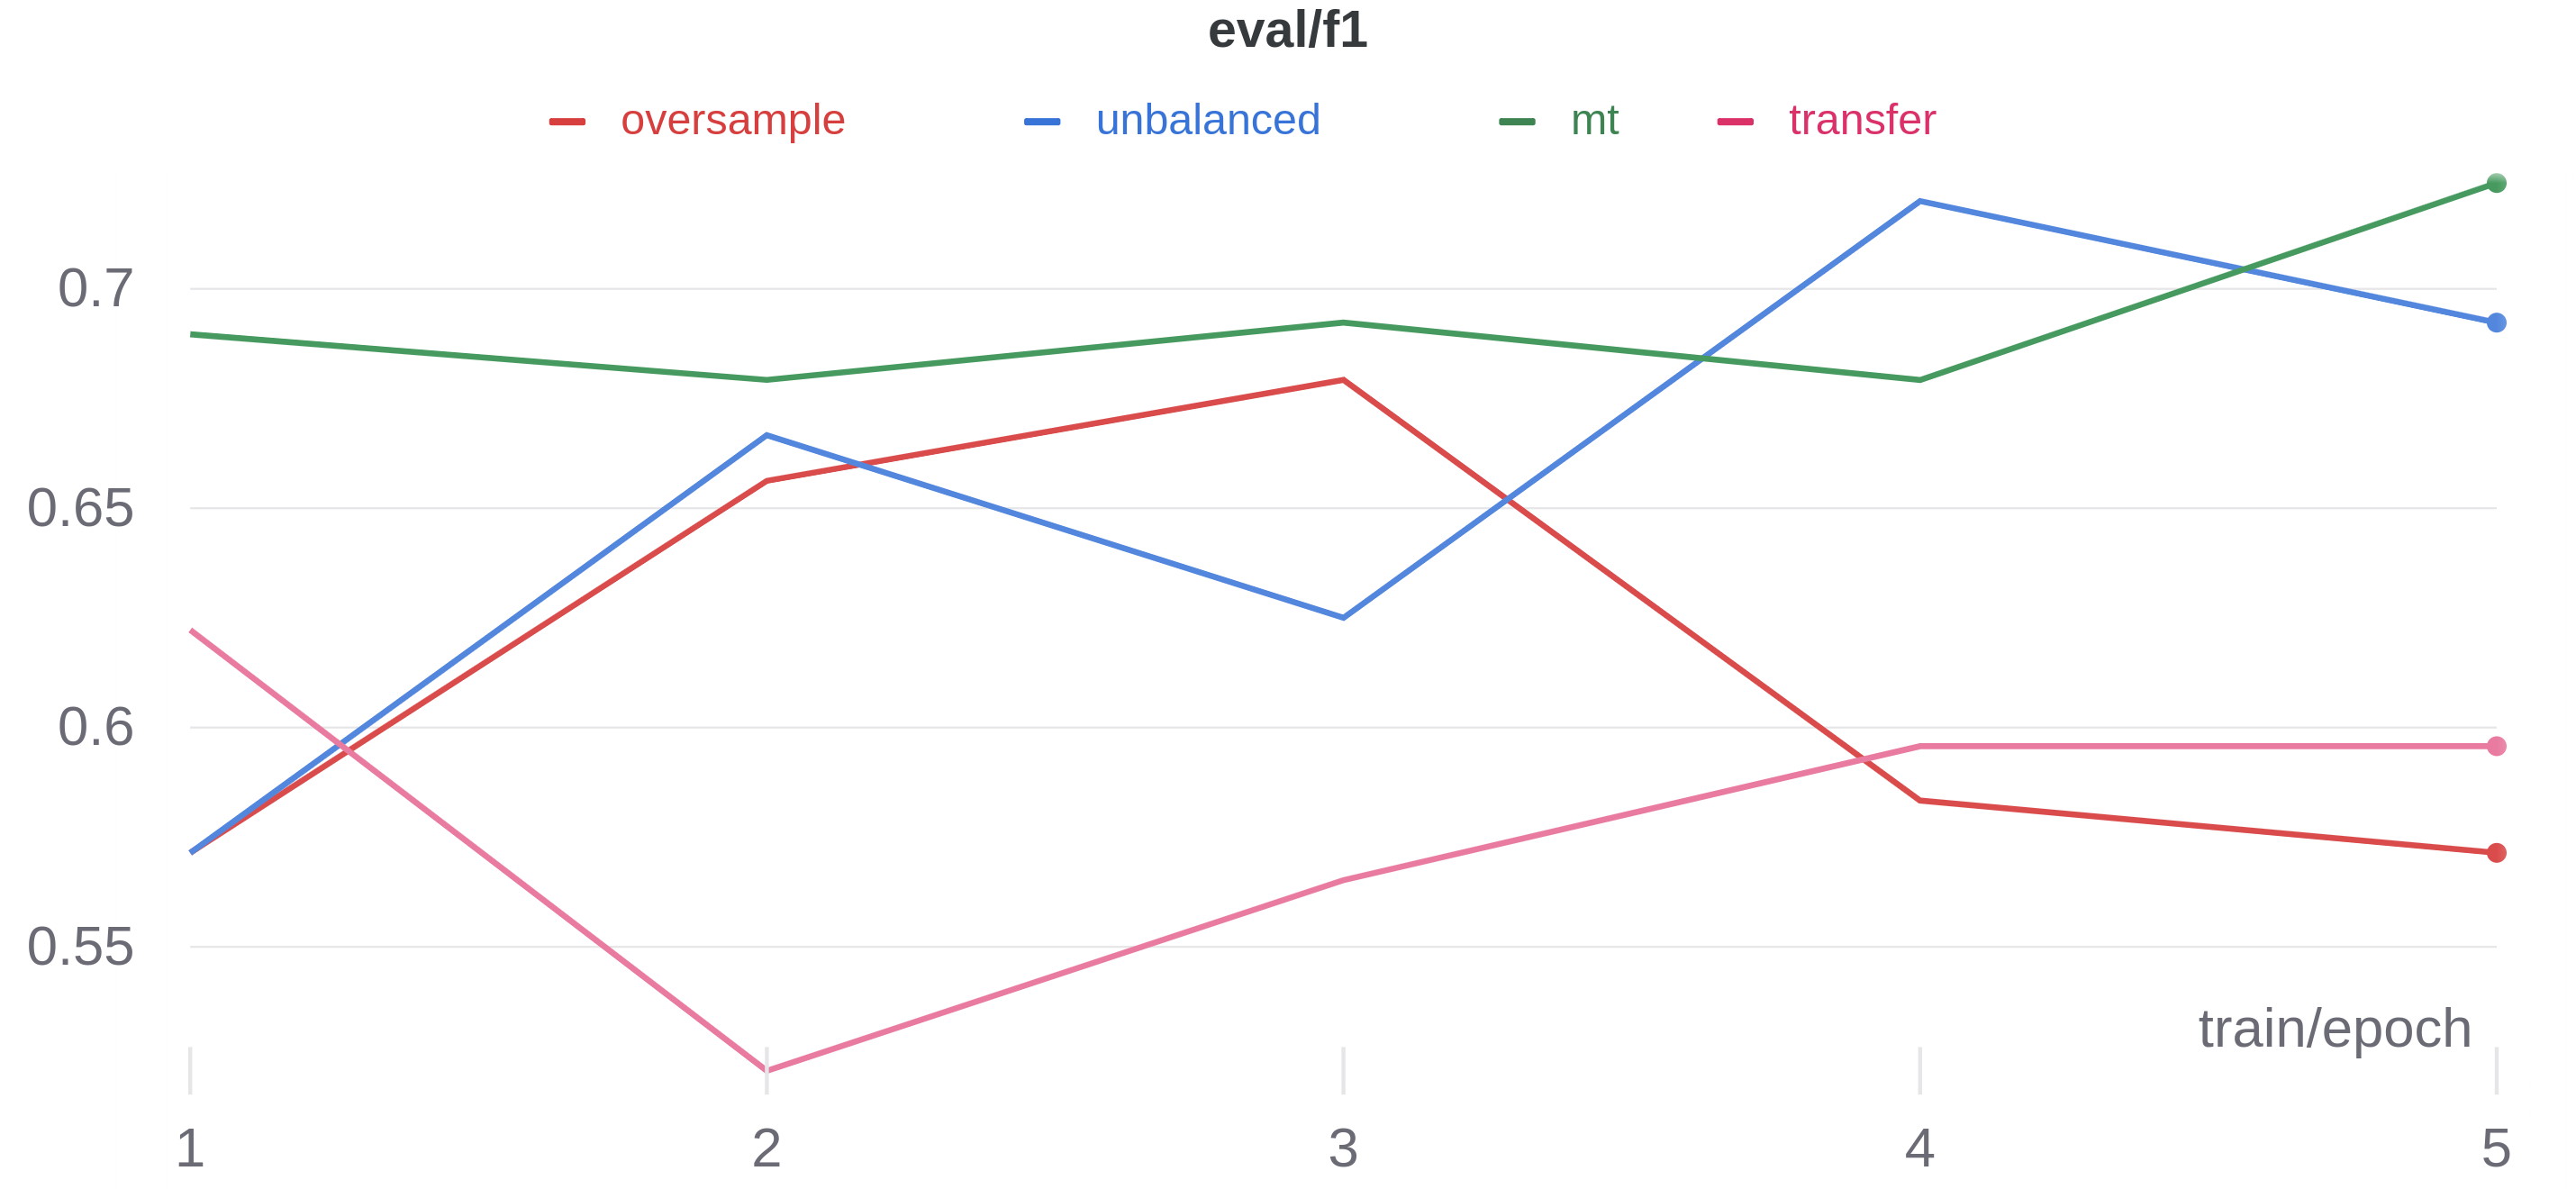

In [ ]:
#@title Resultados test
#@markdown La tabla de resultados muestra las principales métricas sobre el conjunto de test de los distintos modelos. 
import io 

# Crawled from https://wandb.ai/blozano/newtral_prueba/table 
test_results="""'Run','test/f1','test/recall','test/precision','test/FN','test/accuracy'
oversample,0.7272727272727273,0.6741573033707865,0.7894736842105263,58,0.9625
unbalanced,0.7212121212121213,0.6685393258426966,0.7828947368421053,59,0.9616666666666668
mt,0.6862170087976539,0.6573033707865169,0.7177914110429447,61,0.9554166666666668
transfer,0.6036363636363635,0.46629213483146065,0.8556701030927835,95,0.9545833333333332"""

pd.read_csv(io.StringIO(test_results),sep=",")

,'Run','test/f1','test/recall','test/precision','test/FN','test/accuracy'
0,oversample,0.727273,0.674157,0.789474,58,0.962500
1,unbalanced,0.721212,0.668539,0.782895,59,0.961667
2,mt,0.686217,0.657303,0.717791,61,0.955417
3,transfer,0.603636,0.466292,0.855670,95,0.954583


Como puede observarse únicamente el modelo entrenado con *oversampling* consigue superar ligeramente el baseline. Realizaremos el analisis de errores sobre sus predicciones

# Análisis de errores

In [ ]:
#@markdown Recargamos el mejor modelo y sacamos los errores
# import wandb
# # Create a new run
# with wandb.init(project="newtral_prueba") as run:

best_models = ['oversample']
predictions = {}

for model_name in best_models:
#   # Connect an Artifact to the run
#   artifact = run.use_artifact(f'blozano/newtral_prueba/ {model_name}:v0', type='model')
#   artifact_dir = artifact.download()

  # Load your Hugging Face model from that folder
  #  using the same model class
  model = AutoModelForSequenceClassification.from_pretrained(
      './best_model', num_labels=2)

  # Do additional training, or run inference
  trainer = Trainer(model,tokenizer=tokenizer,compute_metrics=compute_metrics)
  predictions[model_name] = trainer.predict(encoded_dataset['test'])

FN_text,TP_text = {},{}

for model_name in predictions:
  preds = np.argmax(predictions[model_name].predictions, axis=1)
  labels = encoded_dataset['test']['labels']
  texts = encoded_dataset['test']['text']
  indices = [i for i,pred in enumerate(preds) if pred == 0 and labels[i]== 1]
  FN_text[model_name] = datasets.Dataset.from_dict({
      'text': [texts[i] for i in indices],
      'length' : [len(texts[i].split()) for i in indices],
      'og_id': indices
  })
  indices = [i for i,pred in enumerate(preds) if pred == 1 and labels[i]== 1]
  TP_text[model_name] = datasets.Dataset.from_dict({
      'text': [texts[i] for i in indices],
      'length' : [len(texts[i].split()) for i in indices],
      'og_id': indices
  })  


In [ ]:
#@markdown Longitud y ejemplos aleatorios de falsos negativos y verdaderos positivos
for model_name in FN_text:
  print(model_name)
  
  vocab,length = [],[]
  for text in FN_text[model_name]['text']:
    tokens = text.split()
    vocab.extend(tokens)

    length.append(len(tokens))
  
  print(
  f"""
  Numero de falsos negativos: {len(FN_text[model_name])}

  Tamaño medio de los falsos negativos: {mean(length)}
  Tamaño mediano de los falsos negativos: {median(length)}
  Tamaño maximo de los falsos negativos {max(length)}
  Tamaño mínimo de los falsos negativos {min(length)}
  """)
  show_random_elements(FN_text[model_name],3)

  
  vocab,length = [],[]
  for text in TP_text[model_name]['text']:
    tokens = text.split()
    vocab.extend(tokens)

    length.append(len(tokens))
  
  print(
  f"""
  Numero de verdaderos positivos: {len(TP_text[model_name])}

  Tamaño medio de los verdaderos positivos: {mean(length)}
  Tamaño mediano de los verdaderos positivos: {median(length)}
  Tamaño maximo de los verdaderos positivos {max(length)}
  Tamaño mínimo de los verdaderos positivos {min(length)}
  """)
  show_random_elements(TP_text[model_name],3)


oversample

  Numero de falsos negativos: 58

  Tamaño medio de los falsos negativos: 29.655172413793103
  Tamaño mediano de los falsos negativos: 25.5
  Tamaño maximo de los falsos negativos 108
  Tamaño mínimo de los falsos negativos 6
  


,text,length,og_id
0,De hecho en aquel en aquella ocasión ese recurso fue fue revocado.,12,704
1,"Por ejemplo en el plan de vivienda joven, las mujeres hasta 35 se pueden acoger de manera prioritaria.",18,678
2,Europa habría admitido que una dictadura esté siendo parte de la Unión Europea.,13,315



  Numero de verdaderos positivos: 120

  Tamaño medio de los verdaderos positivos: 32.208333333333336
  Tamaño mediano de los verdaderos positivos: 29.5
  Tamaño maximo de los verdaderos positivos 88
  Tamaño mínimo de los verdaderos positivos 6
  


,text,length,og_id
0,"No, los liberales alemanes se pegan un batacazo descomunal, no llegan al 5 por ciento para entrar en el Bundestag, se quedan sin representación parlamentaria en el Congreso de los Diputados que sería de Alemania.",35,866
1,"Desgraciadamente, la mala gestión que está pasando en India con la población que tiene ahora creo que nos sitúa en tercer o cuarto lugar en materia de paro.",28,82
2,"Porque, como digo, en Europa en los países modernos de nuestro entorno, este tipo de delitos penales no existe.",19,1573


La distribución por tamaño es similar entre los aciertos y los falsos positivos aunque . 

Al evaluar cualitativamente podemos encontrar algunos patrones que se repiten. 
Dentro de los falsos positivos destaca la repetición de una entidad o palabra dentro de una misma frase:

* [...] el **Tribunal Supremo**, por cierto, con informe en contra del **Tribunal Supremo** y de la Fiscalía del **Tribunal Supremo**.
* El **Gobierno de** España el 21 de mayo hizo una propuesta que el **Gobierno de** Navarra considera insuficiente. 
* **Primaria**, no se van a cerrar centros de atención **primaria**.    
* Y también en términos **observables**, **observables** de la variación [...] con los datos que tenemos acumulados en la **primera**, la **primera** parte del mes.    
* [...] recogen que la gran **mayoría** la inmensa **mayoría** de los españoles, también el votante socialista está contrario a los indultos.   
* [...] se está **avanzando** bastante simétricamente **en todos los** **en todas las** comunidades autónomas se está **avanzando** mucho [...] pues tenemos más capacidad de **avanzar**.
* Es decir no solamente hay que liberar las patentes y **Estados Unidos** se está exportando muy poco desde **Estados Unidos**.	 
* De hecho **en aquel en aquella** ocasión ese recurso fue fue revocado.	
* [...] ese gobierno cada día tiene **mayor debilidad** parlamentaria, pero también **mayor debilidad** ciudadana, **con menos**, **con menos** apoyos.
* De hecho en aquel en aquella ocasión ese recurso **fue fue** revocado.	

Frente a los verdaderos positivos los falsos positivos tienen pocos números mas allá de fechas y, aunque ambos tienen frases de caracter oral, los falsos positivos se distinguen por ser mas coloquiales, tener frases peor formadas o faltas de contexto:

* Bueno, vamos a hablar de bueno, ya hoy toma posesión **los nuevos consejeros nueve consejeros.**
* Otras firmas [se] han recogido contra los indultos que hoy se van a aprobar en el Consejo de Ministros.	
* Y así lo reconoce el Comité Olímpico Internacional, sino que creo que debemos abandonar.	

Es posible que limpiando el dataset de errores se consiga una mejora significativa en el rendimiento del modelo

# Otras lecturas



*   [Overview of the CLEF-2021 CheckThat! Lab Task 1
on Check-Worthiness Estimation in Tweets and
Political Debates](http://ceur-ws.org/Vol-2936/paper-28.pdf)
*   [Claim Check-Worthiness Detection as Positive Unlabelled Learning](https://aclanthology.org/2020.findings-emnlp.43/)




# Anexo: Prueba el modelo!

Para poder probar el modelo es necesario haber ejecutado antes las secciones *Setup* y *Análisis del dataset*, ademas de la subsección *Setup* dentro de este anexo.

In [8]:
#@title Setup
%%capture
from transformers import (
    TextClassificationPipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
best_model = AutoModelForSequenceClassification.from_pretrained('./best_model', num_labels=2)


claim_pipeline = TextClassificationPipeline(model=best_model,tokenizer=tokenizer,device=device)

In [9]:
#@markdown Introduce una frase para saber si es verificable 
import gradio as gr

def is_claim(sentence):
  claim = claim_pipeline(sentence)[0]['label']
  return "claim" if claim=="LABEL_1" else "no claim"

gr.Interface(fn=is_claim, inputs="text", outputs="label").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://59427.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://59427.gradio.app')